TRADE SUMMARY
trade                    : steepener
short_leg                : 5y
long_leg                 : 30y
anchor_leg               : 30y
notional_long            : 6,202,814.4002
notional_short           : 21,982,010.9955
dv01_long_end_$perbp     : 10,000.0000
dv01_short_end_$perbp    : 10,000.0000
dv01_net_end_$perbp      : 0.0000
sharpe_annual            : 0.0624
max_drawdown_$           : -1,716,416.3417
avg_daily_pnl_$          : 158.6235
daily_vol_pnl_$          : 40,385.4275
include_carry            : False
duration_model           : par-bond modified duration approx


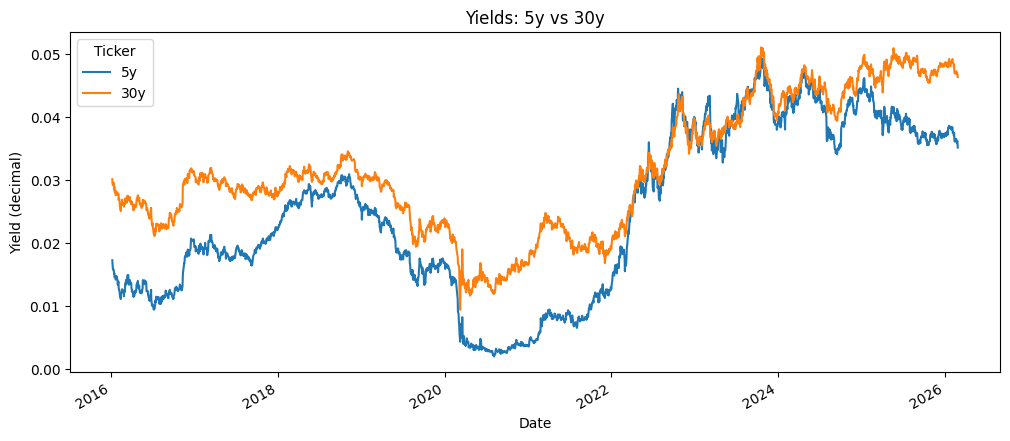

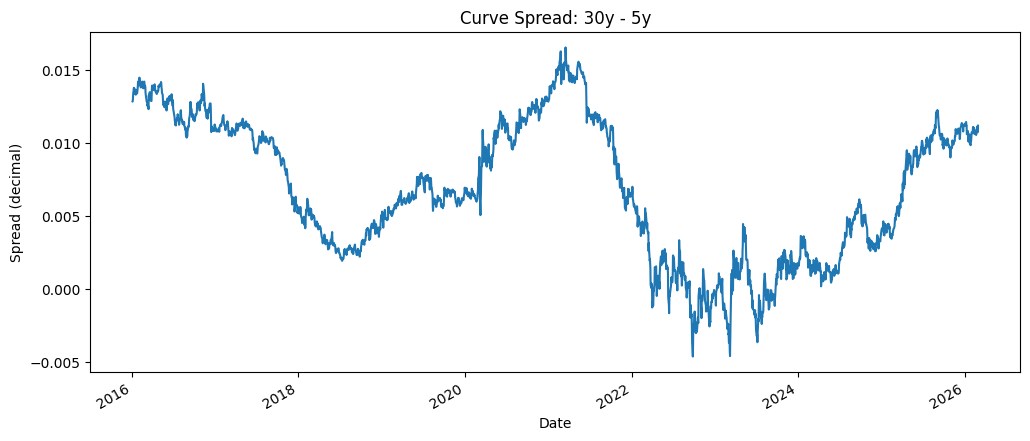

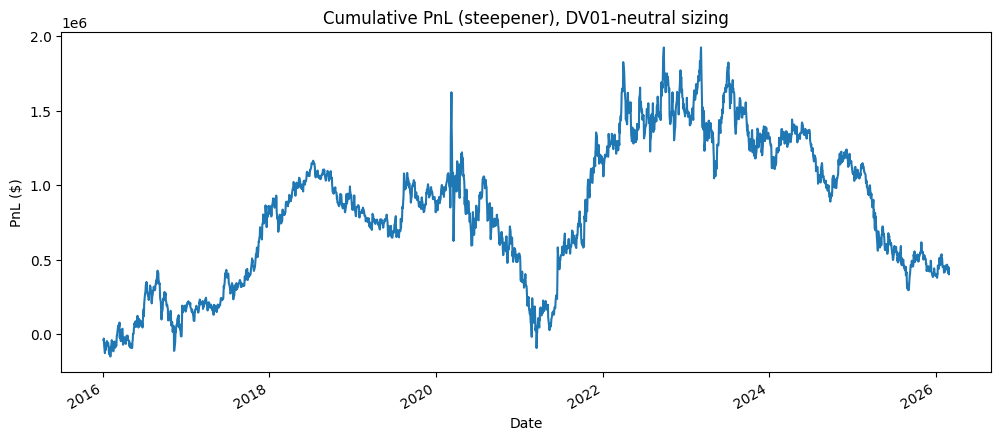

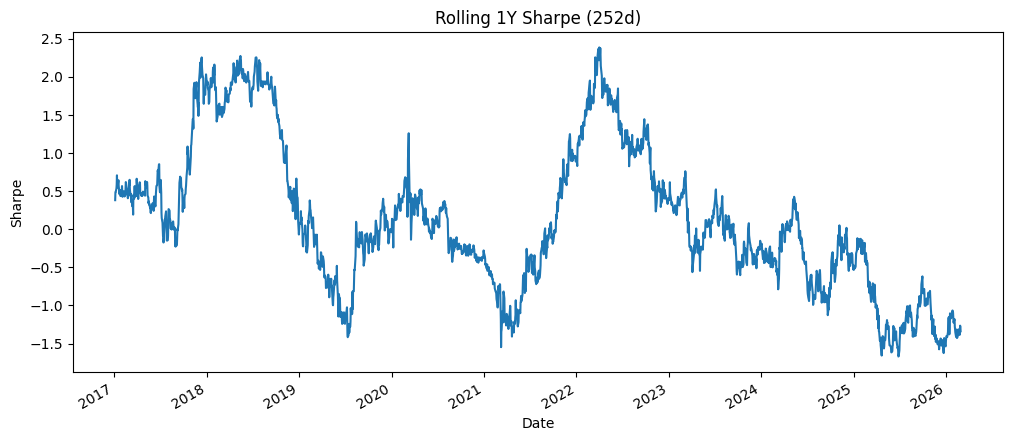

Ticker,5y,30y,dY_short,dY_long,spread,d_spread,dur_short,dur_long,pnl_long,pnl_short,pnl,carry_long,carry_short,cum_pnl
Date,,,,,,,,,,,,,,
2026-02-23,0.03582,0.04696,-0.00068,-0.00029,0.01114,0.00039,4.540804,16.004053,28788.157134,-67874.963879,-39086.806746,0.0,0.0,411791.522637
2026-02-24,0.03598,0.04689,0.00016,-0.00007,0.01091,-0.00023,4.538894,16.017062,6954.530118,15963.876106,22918.406223,0.0,0.0,434709.928860
2026-02-25,0.03619,0.04694,0.00021,0.00005,0.01075,-0.00016,4.536389,16.007769,-4964.301232,20940.889858,15976.588625,0.0,0.0,450686.517486
2026-02-26,0.03583,0.04669,-0.00036,-0.00025,0.01086,0.00011,4.540685,16.054319,24895.109947,-35932.831540,-11037.721593,0.0,0.0,439648.795893
2026-02-27,0.03512,0.04633,-0.00071,-0.00036,0.01121,0.00035,4.549174,16.121714,35999.774933,-71000.099182,-35000.324249,0.0,0.0,404648.471644


In [2]:
# ============================================================
# Yield Curve Trade Simulator (Yahoo Finance + Python)
# DV01-neutral steepener / flattener backtest
# ============================================================

!pip -q install yfinance

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 5)

# -----------------------------
# 1) Data fetch utilities
# -----------------------------
YAHOO_YIELD_TICKERS = {
    "13w": "^IRX",   # 13-week
    "5y":  "^FVX",   # 5-year
    "10y": "^TNX",   # 10-year
    "30y": "^TYX",   # 30-year
}

def fetch_yields(labels=("5y", "10y", "30y"), start="2015-01-01", end=None):
    """
    Fetches Treasury yield index time series from Yahoo Finance.
    Returns yields in DECIMAL (e.g., 0.045 instead of 4.5).
    """
    tickers = [YAHOO_YIELD_TICKERS[l] for l in labels]
    raw = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)

    if isinstance(raw.columns, pd.MultiIndex):
        # Typical yfinance: columns are like ('Adj Close', '^TNX'), ('Close', '^TNX'), etc.
        # These yield tickers usually have usable values in 'Adj Close' or 'Close'
        if ("Adj Close" in raw.columns.get_level_values(0)):
            px = raw["Adj Close"].copy()
        else:
            px = raw["Close"].copy()
    else:
        px = raw.copy()

    # Rename tickers -> labels
    inv_map = {v: k for k, v in YAHOO_YIELD_TICKERS.items()}
    px = px.rename(columns=inv_map)

    # Some of these are quoted in "percent * 100" units:
    # ^TNX ~ 45 means 4.5%, ^FVX similar, ^TYX similar, ^IRX similar.
    # Convert to decimal yield:
    y = px / 100.0

    # Clean missing values
    y = y.sort_index().ffill().dropna()

    return y[list(labels)]


# -----------------------------
# 2) Bond duration approximation (par bond)
# -----------------------------
def par_bond_modified_duration(y, maturity_years, freq=2):
    """
    Vectorized modified duration of a par bond.
    y can be a scalar OR numpy array.
    Returns array of modified durations.
    """

    y = np.asarray(y)
    y = np.maximum(y, 1e-6)

    n = int(maturity_years * freq)
    t = np.arange(1, n + 1)

    # reshape for broadcasting
    per = (y / freq).reshape(-1, 1)        # shape (T, 1)
    t = t.reshape(1, -1)                   # shape (1, n)

    df = 1.0 / (1.0 + per) ** t

    c = per  # par bond coupon per period

    cf = np.ones_like(df) * c
    cf[:, -1] += 1.0

    price = np.sum(cf * df, axis=1)

    macaulay_periods = np.sum(t * cf * df, axis=1) / price
    macaulay_years = macaulay_periods / freq
    mod_dur = macaulay_years / (1.0 + y / freq)

    return mod_dur


def dv01(notional, mod_duration):
    """
    DV01 = dollar change for a 1bp move in yield.
    For small changes: dP ≈ -Duration * Δy * Notional
    1bp = 0.0001 in yield decimal.
    """
    return notional * mod_duration * 0.0001


# -----------------------------
# 3) Trade simulator
# -----------------------------
def simulate_curve_trade(
    yields_df,
    short_leg="5y",
    long_leg="30y",
    trade="steepener",      # "steepener" or "flattener"
    dv01_target=10_000,     # target DV01 on the "anchor" leg (in $ per bp)
    freq=2,
    include_carry=False,
    trading_days=252
):
    """
    Simulate a DV01-neutral curve trade using yield changes.

    Convention:
      - "Steepener" means LONG long-end duration and SHORT short-end duration
        (profits if long-end yields rise less than short-end, OR spread widens depending on move).
      - "Flattener" is the opposite.

    Approach:
      - Compute daily yield changes for each leg.
      - Compute mod duration each day based on yield level (par-bond approx).
      - Choose notionals so that DV01 exposure is neutral:
          DV01_long_leg ≈ DV01_short_leg (in magnitude)
      - Daily PnL ≈ -position * modDur * notional * Δy

    Returns:
      results DataFrame with yields, spread, pnl, cum_pnl, etc.
      and a dict of trade settings.
    """
    df = yields_df[[short_leg, long_leg]].copy()

    # Determine maturities from labels like "5y"
    def parse_years(lbl):
        return int(lbl.replace("y", ""))

    T_short = parse_years(short_leg)
    T_long  = parse_years(long_leg)

    # Daily yield changes (decimal)
    df["dY_short"] = df[short_leg].diff()
    df["dY_long"]  = df[long_leg].diff()

    # Spread (long - short)
    df["spread"] = df[long_leg] - df[short_leg]
    df["d_spread"] = df["spread"].diff()

    # Durations each day (approx par bond)
    df["dur_short"] = par_bond_modified_duration(df[short_leg].values, T_short, freq=freq)
    df["dur_long"]  = par_bond_modified_duration(df[long_leg].values, T_long,  freq=freq)

    # Choose notionals to hit dv01_target on the anchor leg, and DV01-neutral overall.
    # We'll anchor DV01 of the long leg to dv01_target by default, then size the other leg.
    # You can swap if you want by changing which leg is "anchor".
    N_long = dv01_target / (df["dur_long"].iloc[-1] * 0.0001)   # notional so that DV01_long ≈ dv01_target
    # Size short leg to match DV01 magnitude:
    dv01_long_now = dv01(N_long, df["dur_long"].iloc[-1])
    N_short = dv01_long_now / (df["dur_short"].iloc[-1] * 0.0001)

    # Positions:
    # steepener: + long_leg, - short_leg
    # flattener: - long_leg, + short_leg
    if trade.lower() == "steepener":
        pos_long = +1
        pos_short = -1
    elif trade.lower() == "flattener":
        pos_long = -1
        pos_short = +1
    else:
        raise ValueError("trade must be 'steepener' or 'flattener'")

    # Daily PnL approximation
    # PnL ≈ -position * duration * notional * Δy
    df["pnl_long"]  = -pos_long  * df["dur_long"]  * N_long  * df["dY_long"]
    df["pnl_short"] = -pos_short * df["dur_short"] * N_short * df["dY_short"]
    df["pnl"] = df["pnl_long"] + df["pnl_short"]

    # Optional carry (very simplified):
    # Treat as earning yield/252 on par notional for longs, paying for shorts.
    if include_carry:
        df["carry_long"]  = pos_long  * (df[long_leg] / trading_days) * N_long
        df["carry_short"] = pos_short * (df[short_leg] / trading_days) * N_short
        df["pnl"] = df["pnl"] + df["carry_long"] + df["carry_short"]
    else:
        df["carry_long"] = 0.0
        df["carry_short"] = 0.0

    df = df.dropna().copy()
    df["cum_pnl"] = df["pnl"].cumsum()

    # Basic risk stats
    daily = df["pnl"]
    mu = daily.mean()
    sigma = daily.std(ddof=1)
    sharpe = (mu / sigma) * np.sqrt(trading_days) if sigma > 0 else np.nan

    cum = df["cum_pnl"]
    peak = cum.cummax()
    drawdown = cum - peak
    max_dd = drawdown.min()

    # Approx DV01 exposure at the end (should be close to neutral)
    dv01_long_end  = dv01(N_long,  df["dur_long"].iloc[-1])
    dv01_short_end = dv01(N_short, df["dur_short"].iloc[-1])

    info = {
        "trade": trade.lower(),
        "short_leg": short_leg,
        "long_leg": long_leg,
        "anchor_leg": long_leg,
        "notional_long": float(N_long),
        "notional_short": float(N_short),
        "dv01_long_end_$perbp": float(dv01_long_end),
        "dv01_short_end_$perbp": float(dv01_short_end),
        "dv01_net_end_$perbp": float(pos_long * dv01_long_end + pos_short * dv01_short_end),
        "sharpe_annual": float(sharpe),
        "max_drawdown_$": float(max_dd),
        "avg_daily_pnl_$": float(mu),
        "daily_vol_pnl_$": float(sigma),
        "include_carry": bool(include_carry),
        "duration_model": "par-bond modified duration approx",
    }

    return df, info


# -----------------------------
# 4) Plot & report helpers
# -----------------------------
def plot_results(df, info):
    short_leg = info["short_leg"]
    long_leg  = info["long_leg"]

    # 1) yields
    ax = df[[short_leg, long_leg]].plot(title=f"Yields: {short_leg} vs {long_leg}")
    ax.set_ylabel("Yield (decimal)")
    plt.show()

    # 2) spread
    ax = df["spread"].plot(title=f"Curve Spread: {long_leg} - {short_leg}")
    ax.set_ylabel("Spread (decimal)")
    plt.show()

    # 3) cumulative pnl
    ax = df["cum_pnl"].plot(title=f"Cumulative PnL ({info['trade']}), DV01-neutral sizing")
    ax.set_ylabel("PnL ($)")
    plt.show()

    # 4) rolling 1Y sharpe (optional view)
    window = 252
    if len(df) > window:
        roll = df["pnl"].rolling(window)
        roll_sharpe = (roll.mean() / roll.std(ddof=1)) * np.sqrt(252)
        ax = roll_sharpe.plot(title="Rolling 1Y Sharpe (252d)")
        ax.set_ylabel("Sharpe")
        plt.show()


def print_trade_summary(info):
    print("============================================================")
    print("TRADE SUMMARY")
    print("============================================================")
    for k, v in info.items():
        if isinstance(v, float):
            print(f"{k:25s}: {v:,.4f}")
        else:
            print(f"{k:25s}: {v}")
    print("============================================================")


# ============================================================
# 5) RUN IT (example)
# ============================================================

# Pull yield data (Yahoo)
y = fetch_yields(labels=("5y", "10y", "30y"), start="2016-01-01")

# Example: 5s30s steepener
df, info = simulate_curve_trade(
    yields_df=y,
    short_leg="5y",
    long_leg="30y",
    trade="steepener",
    dv01_target=10_000,      # $10k per bp DV01 on anchor leg
    include_carry=False
)

print_trade_summary(info)
plot_results(df, info)

df.tail()